<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Unsupervised/Notebooks/Unsupervised_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised First Pass


### Data Engineering

Access data from GitHub. Follow data engineering methods described in EDA - combine csv files, fill missing values, and drop unneeded features.

In [1]:
import requests
import os
import pandas as pd
import glob

repo_api_url = "https://api.github.com/repos/GeoLinkCoding/EarthResources_DataScience/contents/Unsupervised/Data"
response = requests.get(repo_api_url).json()

# Extract filenames
files = [file["download_url"] for file in response if file["type"] == "file"]

# Download files
for file in files:
    os.system(f"wget {file}")

csv_files = glob.glob("*.csv")
dataframes = []
for file in csv_files:
  df = pd.read_csv(file,skiprows=16)
  df['filename'] = file[:-4]
  dataframes.append(df)
df_combined = pd.concat(dataframes).set_index('filename',append=True)

In [2]:
df_filled = df_combined.replace("N.A.",0)
non_numeric_cols = df_filled.select_dtypes(exclude=['number']).columns
for col in non_numeric_cols:
  df_filled[col] = pd.to_numeric(df_filled[col],errors='coerce')
col = df_filled.columns.tolist()
swir_num = [i for i in range(2,16)]
tir_num = [i for i in range(24,48)]
itors = swir_num + tir_num
good_cols = [col[c] for c in itors]
good_cols.append('Depth_from_(m)')
bad_cols = [c for c in col if c not in good_cols]
df_drop = df_filled.drop(columns=bad_cols)
df_drop = df_drop.drop(columns=['Misc-Silicate_(System_TIR)','Zeolite_(System_TIR)','Tourmaline_(System_TIR)'])

<ipython-input-2-d21f6e6e9159>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled = df_combined.replace("N.A.",0)


In [3]:
df_minerals = df_drop.copy()
df_minerals.head()

,,Depth_from_(m),Kaolin_(System_SWIR),White-Mica_(System_SWIR),Smectite_(System_SWIR),Other-AlOH_(System_SWIR),Chlorite_(System_SWIR),Dark-Mica_(System_SWIR),Amphibole_(System_SWIR),Serpentine_(System_SWIR),Other-MgOH_(System_SWIR),...,Dark-Mica_(System_TIR),Amphibole_(System_TIR),Serpentine_(System_TIR),Other-MgOH_(System_TIR),Epidote_(System_TIR),Carbonate_(System_TIR),Sulphate_(System_TIR),Phosphate_(System_TIR),Oxide_(System_TIR),INVALID_(System_TIR)
,filename,,,,,,,,,,,,,,,,,,,,,
0,SM_13CGDD001,0.0,0.335511,0.533736,0.0,0.0,0.089514,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000686,0.0,0.0,0.000000,0.0
1,SM_13CGDD001,1.0,0.171069,0.660994,0.0,0.0,0.141934,0.0,0.001429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011307,0.0,0.0,0.000000,0.0
2,SM_13CGDD001,2.0,0.155520,0.637633,0.0,0.0,0.202110,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.005541,0.0,0.0,0.000887,0.0
3,SM_13CGDD001,3.0,0.086169,0.653904,0.0,0.0,0.247442,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.023098,0.0,0.0,0.000000,0.0
4,SM_13CGDD001,4.0,0.130084,0.615280,0.0,0.0,0.251946,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000904,0.0,0.0,0.000000,0.0


### Libraries

In [38]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Standardization

Unsupervised learning benefits significantly from standardized data. Once data is standardized, a second dataset is created without the depth feature.

In [26]:
standardized = StandardScaler().fit_transform(df_minerals)
df_standard = pd.DataFrame(standardized,columns=df_minerals.columns)
depth = df_standard['Depth_from_(m)']
df_nodepth = df_standard.drop(columns=['Depth_from_(m)'])
df_standard.head()

,Depth_from_(m),Kaolin_(System_SWIR),White-Mica_(System_SWIR),Smectite_(System_SWIR),Other-AlOH_(System_SWIR),Chlorite_(System_SWIR),Dark-Mica_(System_SWIR),Amphibole_(System_SWIR),Serpentine_(System_SWIR),Other-MgOH_(System_SWIR),...,Dark-Mica_(System_TIR),Amphibole_(System_TIR),Serpentine_(System_TIR),Other-MgOH_(System_TIR),Epidote_(System_TIR),Carbonate_(System_TIR),Sulphate_(System_TIR),Phosphate_(System_TIR),Oxide_(System_TIR),INVALID_(System_TIR)
0,-1.214872,8.839627,0.709260,-0.294572,-0.335837,-0.590346,-0.244005,-0.189850,-0.238264,-0.122075,...,-0.38771,-0.218998,-0.214153,-0.202953,-0.12474,-0.518917,-0.256923,-0.077693,-0.163173,-0.120754
1,-1.210043,4.436746,1.101004,-0.294572,-0.335837,-0.427856,-0.244005,-0.171354,-0.238264,-0.122075,...,-0.38771,-0.218998,-0.214153,-0.202953,-0.12474,-0.470567,-0.256923,-0.077693,-0.163173,-0.120754
2,-1.205215,4.020416,1.029089,-0.294572,-0.335837,-0.241325,-0.244005,-0.189850,-0.238264,-0.122075,...,-0.38771,-0.218998,-0.214153,-0.202953,-0.12474,-0.496814,-0.256923,-0.077693,-0.018067,-0.120754
3,-1.200386,2.163584,1.079180,-0.294572,-0.335837,-0.100806,-0.244005,-0.189850,-0.238264,-0.122075,...,-0.38771,-0.218998,-0.214153,-0.202953,-0.12474,-0.416888,-0.256923,-0.077693,-0.163173,-0.120754
4,-1.195557,3.339384,0.960279,-0.294572,-0.335837,-0.086845,-0.244005,-0.189850,-0.238264,-0.122075,...,-0.38771,-0.218998,-0.214153,-0.202953,-0.12474,-0.517922,-0.256923,-0.077693,-0.163173,-0.120754


### Dimensionality Reduction

The dataset without depth, only mineral abundances, is reduced.

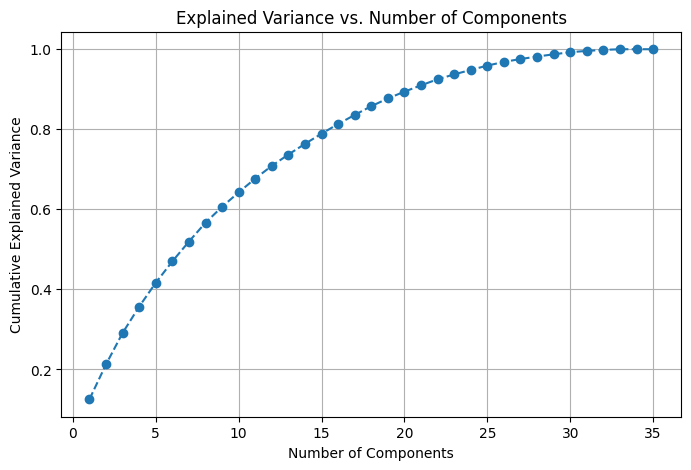

In [28]:
# Fit PCA on full dataset
pca = PCA()
pca.fit(df_nodepth)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

With a variance of ~80% and a lower feature count of 15 from 35, PCA to reduce features to 15 will be further evaluated.

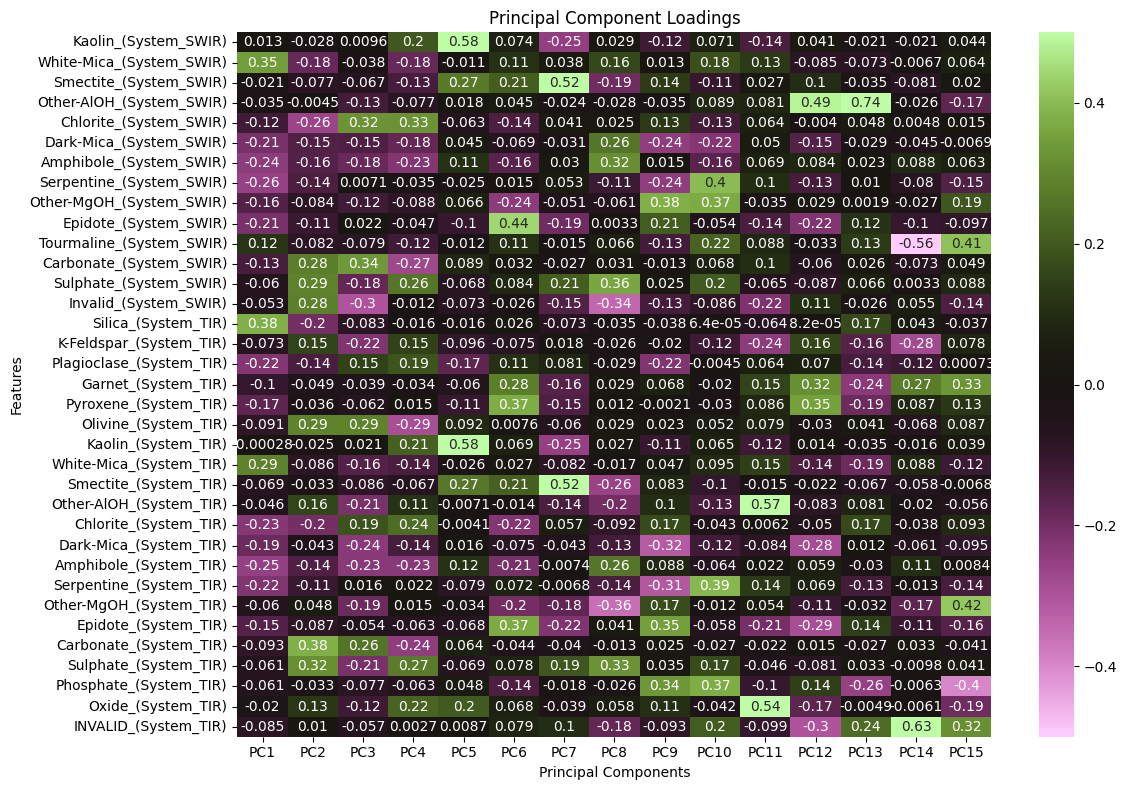

In [29]:
pca = PCA(n_components=15)  # Specify the number of PCs
pca_data = pca.fit_transform(df_nodepth)

# Create a DataFrame for loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(15)],
                        index=df_nodepth.columns)
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='vanimo', cbar=True, vmin=-0.5, vmax=0.5)
plt.title('Principal Component Loadings')
plt.ylabel('Features')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()

Feature importance is the absolute value of each variable load and shows how much weight an original variable holds on the new. However, in this plot, the sign is included since the main objective of this analysis is to understand feature relationships. An example relationship to gather from this matrix is PC5, which has identical feature importance between SWIR and TIR abundances for kaolin and smectite. It also shows that as PC5 increases, there's a general increase in kaolin and smectite, giving indication of a small correlation unseen in the EDA. Another example is PC9, which has negative correlation to dark-mica and serpentine. As PC9 decreases, these two minerals have a general increase with a corresponding decrease in epidote, phosphate, and other-MgOH indicating an inverse correlation between these groups.

### Clustering

Clustering is performed on 4 datasets: Original data, PCA reduced data with depth added back, Original data with no depth feature, and PCA reduced data with no depth feature.

In [30]:
pca_depth = np.hstack((pca_data,depth.values.reshape(-1,1)))

In [ ]:
def avg_silhouette_scores(data, cluster_range, n_iterations=10):
    avg_silhouette_scores = []
    for n_clusters in cluster_range:
        scores = []
        for _ in range(n_iterations):
            kmeans = KMeans(n_clusters=n_clusters, random_state=None)  # Random state is not fixed for variability
            labels = kmeans.fit_predict(data)
            score = silhouette_score(data, labels)
            scores.append(score)
        avg_silhouette_scores.append(np.mean(scores))
    return avg_silhouette_scores

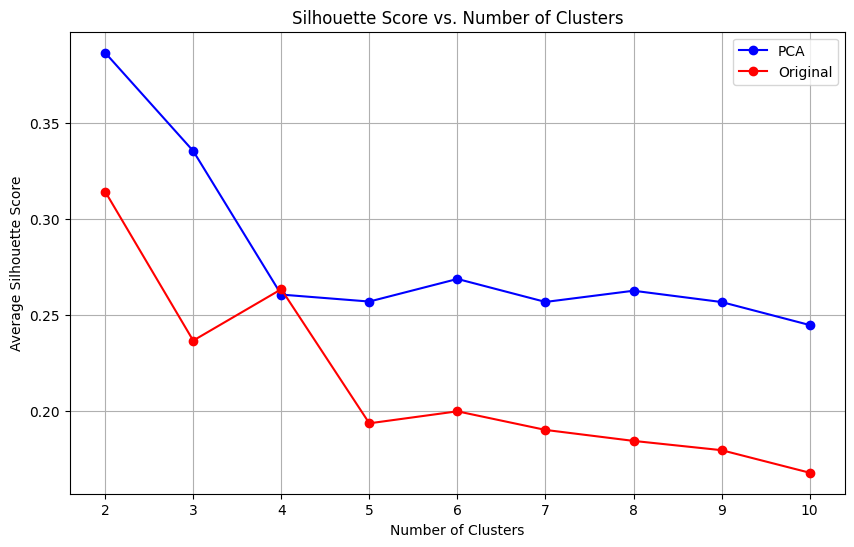

In [31]:
cluster_range = range(2, 11)  # Minimum of 2 clusters for silhouette score
silhouette_scores_pca = avg_silhouette_scores(pca_depth, cluster_range)
silhouette_scores_orig = avg_silhouette_scores(df_standard, cluster_range)
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_pca, marker='o', linestyle='-', color='b',label='PCA')
plt.plot(cluster_range, silhouette_scores_orig, marker='o', linestyle='-', color='r',label='Original')
plt.xticks(cluster_range)
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.legend()
plt.show()

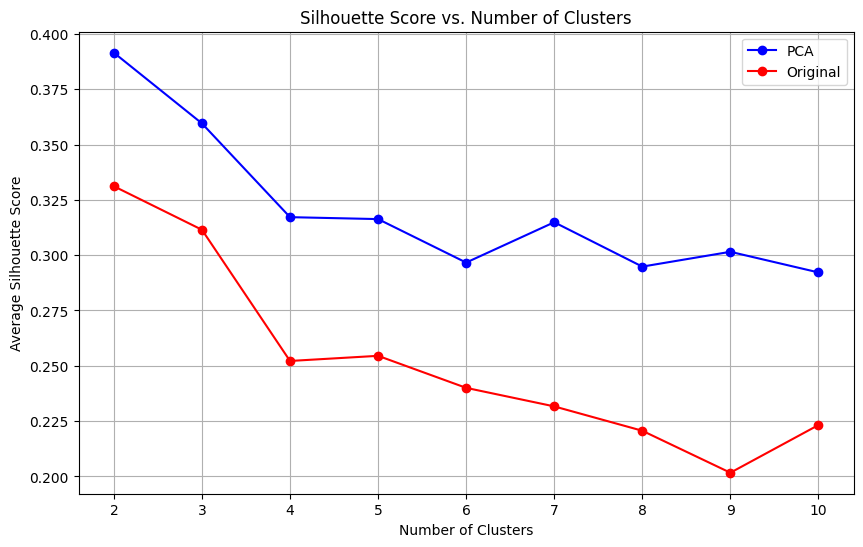

In [32]:
cluster_range = range(2, 11)  # Minimum of 2 clusters for silhouette score
silhouette_scores_pca = avg_silhouette_scores(pca_data, cluster_range)
silhouette_scores_orig = avg_silhouette_scores(df_nodepth, cluster_range)
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_pca, marker='o', linestyle='-', color='b',label='PCA')
plt.plot(cluster_range, silhouette_scores_orig, marker='o', linestyle='-', color='r',label='Original')
plt.xticks(cluster_range)
plt.title('Silhouette Score vs. Number of Clusters (Without Depth)')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.legend()
plt.show()

PCA reduced data with and without depth achieves slightly better clustering results. Adding depth into the datasets doesn't make a significant difference between scores.

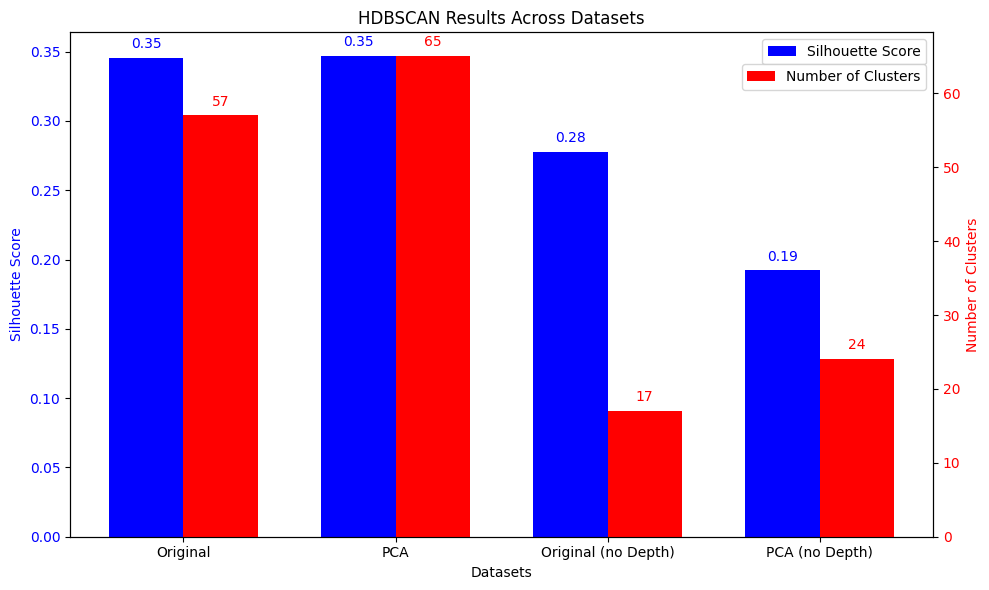

In [67]:
datasets = [df_standard, pca_depth, df_nodepth, pca_data]
dataset_labels = ['Original','PCA','Original (no Depth)','PCA (no Depth)']
results = []

for idx, data in enumerate(datasets):
    clusterer = HDBSCAN()
    clusterer.fit(data)

    labels = clusterer.labels_

    # Exclude noise points for silhouette score
    valid_points = labels != -1
    if np.sum(valid_points) > 1 and len(set(labels[valid_points])) > 1:
        silhouette_avg = silhouette_score(data[valid_points], labels[valid_points])
    else:
        silhouette_avg = np.nan  # Handle cases with too few points or clusters

    # Number of clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    results.append((dataset_labels[idx], silhouette_avg, n_clusters))

# Separate results for plotting
labels, silhouette_scores, cluster_counts = zip(*results)

# Plotting with side-by-side bars
bar_width = 0.35  # Width of the bars
x = np.arange(len(labels))  # Dataset indices

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for silhouette scores (shifted left by half the bar width)
ax1.bar(x - bar_width / 2, silhouette_scores, bar_width, label="Silhouette Score", color="blue")
ax1.set_xlabel("Datasets")
ax1.set_ylabel("Silhouette Score", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("HDBSCAN Results Across Datasets")

# Creating a second y-axis for the number of clusters
ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, cluster_counts, bar_width, label="Number of Clusters", color="red")
ax2.set_ylabel("Number of Clusters", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Adding legends in the upper right corner (without overlapping)
ax1.legend(loc="upper right", bbox_to_anchor=(1, 1))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.95))

# Annotating bars with values
for i in range(len(labels)):
    ax1.annotate(f"{silhouette_scores[i]:.2f}",
                 xy=(x[i] - bar_width / 2, silhouette_scores[i]),
                 xytext=(0, 5), textcoords="offset points",
                 ha="center", va="bottom", color="blue")

    ax2.annotate(f"{cluster_counts[i]}",
                 xy=(x[i] + bar_width / 2, cluster_counts[i]),
                 xytext=(0, 5), textcoords="offset points",
                 ha="center", va="bottom", color="red")

# Adjust x-ticks for better readability
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

plt.tight_layout()
plt.show()

HDBSCAN sets the number of clusters automatically and puts outliers into a "-1" cluster which can be excluded from scoring metrics. A significant number of cluster groups was a common theme for this method, with similar scores to kmeans.

### Analysis Review

For the purpose of the project, PCA was the most helpful method, it broke down the data into a more manageable size and allowed easier analysis in feature relationships than the other two methods could, though this is mainly due to dimension size.

HDBSCAN was the least helpful method. While it's feature to automatically set the optimal number of components is helpful, for the purpose of this project, the high number of compenents only adds more of a challenge at exploring feature relationships, and makes plotting relationships almost impossible. Even with higher components, it still performed roughly equivalent to kmeans in silhouette score.

PCA was scored through variance which quantifies how much information from the original data is retained.

Silhouette score was used for the two clustering methods. It measures how similar a point is to it's cluster compared to other clusters. This value can range from -1 to 1, with scores above 0.7 being strong results, over 0.5 are good results, and over 0.25 is weak. As dimensionality increases, high scores are increasingly unlikely. This was clear against my dataset where even with lower dimensions from PCA, silhouette scores were weak even with an advanced algorithm like HDBSCAN.

PCA loding results were able to show some feature relationships to study further. PC12 shows a negative correlation between other-AlOH and dark-mica/epidote. Both of these latter two minerals contain aluminum oxides, thus if different AlOH containing minerals are present, an inverse relation between these is rational. PC7 shows an inverse relation between smectite/sulphate and kaolin/epidote. Smectites are often formed in volcanic hydrothermal systems, where sulphates are also likely to be found, whereas kaolin is associated more with clay and epidote with metamorphic processes so these slight correlations align with geologic processes.

The purpose of the project was to take highly detailed mineral log data from a central location and derive possible geologic patterns. Coming from a background more heavily focused in physics, I want to grow my geology knowledge in anyway I can. Using data anlysis, something I'm more familiar with, to help broaden my geologic understanding is a unique challenge that if successful can bring a lot of academic benefits.

Data was preprocessed in several ways. First, all mineral logs were combined into one dataset. Next, "N.A." values needed to be filled. The metadata is clear that "N.A." values are indicative of mineral abundances so low they cannot be measured so setting them to zero is the best solution. With 50+ features, any feature dropping I could do was essential to simplify the data. Features that were 0 at every data point were dropped, as were features that were not clealy just mineral abundances. Finally, data was standardized to make sure all features could be fairly represented in the unsupervised learning process.

A decision that stumped me was whether to include or disclude depth from the analysis. It is certain that depth plays a key role in mineral abundances, however, the goal of the project is to specifically study mineral abundance relationships to each other. Ultimately, depth was removed for dimensionailty reduction and later included to compare clustering results with and without it. Cluster scores remained mostly unchanged with and without depth, but including depth in PCA would have likely added to the compexity of an already complex dataset.

Dimensionality reduction played a fantastic role in helping explore relationships in this large group of data. Further work into the project will explore other reduction methods to highlight hidden mineral patterns and see if they improve clustering results.